In [20]:
import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
from rdkit.Chem import AllChem


feature_list =['Temp_C', 'Concentration']
methods = ['ABC','PSO','Random']
GT_data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/experiment_index.csv')

# 計算四分位數
q1 = GT_data['yield'].quantile(0.25)
q2 = GT_data['yield'].quantile(0.50)  # median
q3 = GT_data['yield'].quantile(0.75)
q4 = GT_data['yield'].quantile(0.90)  

print(f"Q1 (25%): {q1:.4f}")
print(f"Q2 (median): {q2:.4f}")
print(f"Q3 (75%): {q3:.4f}")
print(f"Q4 (90%): {q4:.4f}")


ABC = []
PSO = []
Random = []

# 讀取 data1.csv 到 data10.csv
for method in methods:
    if method == 'ABC':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            ABC.append(df[10:])
    if method =='PSO':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            PSO.append(df[10:])
    if method =='Random':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            Random.append(df[10:])

# 合併成一個大 DataFrame
ABC = pd.concat(ABC, ignore_index=True)
PSO = pd.concat(PSO, ignore_index=True)
Random = pd.concat(Random, ignore_index=True)


# 從SMILES生成Morgan fingerprints
ABC_Lig_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['Ligand_SMILES']]
ABC_Base_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['Base_SMILES']]
ABC_Solv_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['Solvent_SMILES']]

PSO_Lig_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['Ligand_SMILES']]
PSO_Base_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['Base_SMILES']]
PSO_Solv_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['Solvent_SMILES']]

Random_Lig_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in Random['Ligand_SMILES']]
Random_Base_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in Random['Base_SMILES']]
Random_Solv_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in Random['Solvent_SMILES']]

GT_Lig_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in GT_data['Ligand_SMILES']]
GT_Base_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in GT_data['Base_SMILES']]
GT_Solv_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in GT_data['Solvent_SMILES']]

# 將fingerprints轉換為numpy數組
ABCfp_array = np.concatenate((np.array([list(fp) for fp in ABC_Lig_fingerprints]), np.array([list(fp) for fp in ABC_Base_fingerprints]), np.array([list(fp) for fp in ABC_Solv_fingerprints])), axis=1)
PSOfp_array = np.concatenate((np.array([list(fp) for fp in PSO_Lig_fingerprints]), np.array([list(fp) for fp in PSO_Base_fingerprints]), np.array([list(fp) for fp in PSO_Solv_fingerprints])), axis=1)
Randomfp_array = np.concatenate((np.array([list(fp) for fp in Random_Lig_fingerprints]), np.array([list(fp) for fp in Random_Base_fingerprints]), np.array([list(fp) for fp in Random_Solv_fingerprints])), axis=1)
GTfp_array = np.concatenate((np.array([list(fp) for fp in GT_Lig_fingerprints]), np.array([list(fp) for fp in GT_Base_fingerprints]), np.array([list(fp) for fp in GT_Solv_fingerprints])), axis=1)

fp_array = np.concatenate((ABCfp_array, PSOfp_array, Randomfp_array, GTfp_array), axis=0)
# 建立 labels

labels = (
    ['ABC'] * len(ABCfp_array) +
    ['PSO'] * len(PSOfp_array) +
    ['Random'] * len(Randomfp_array) +
    ['GT'] * len(GTfp_array)
)


Yield = (pd.concat([ABC, PSO, Random, GT_data], ignore_index=True))[['yield']]

#print(latent)
print(Yield)

ABC = ABC[feature_list]
PSO = PSO[feature_list]
Random = Random[feature_list]  
GT_data = GT_data[feature_list]

c_df = pd.concat([ABC, PSO,Random,GT_data], ignore_index=True)

c_df = c_df.values
c_df = np.concatenate((c_df, fp_array), axis=1)


Q1 (25%): 0.0000
Q2 (median): 6.1150
Q3 (75%): 26.7025
Q4 (90%): 55.9600


        yield
0     47.2885
1     46.3121
2     31.6143
3     31.4607
4     28.3559
...       ...
3479   0.4600
3480   6.1300
3481   0.7800
3482   1.8000
3483   1.0600

[3484 rows x 1 columns]


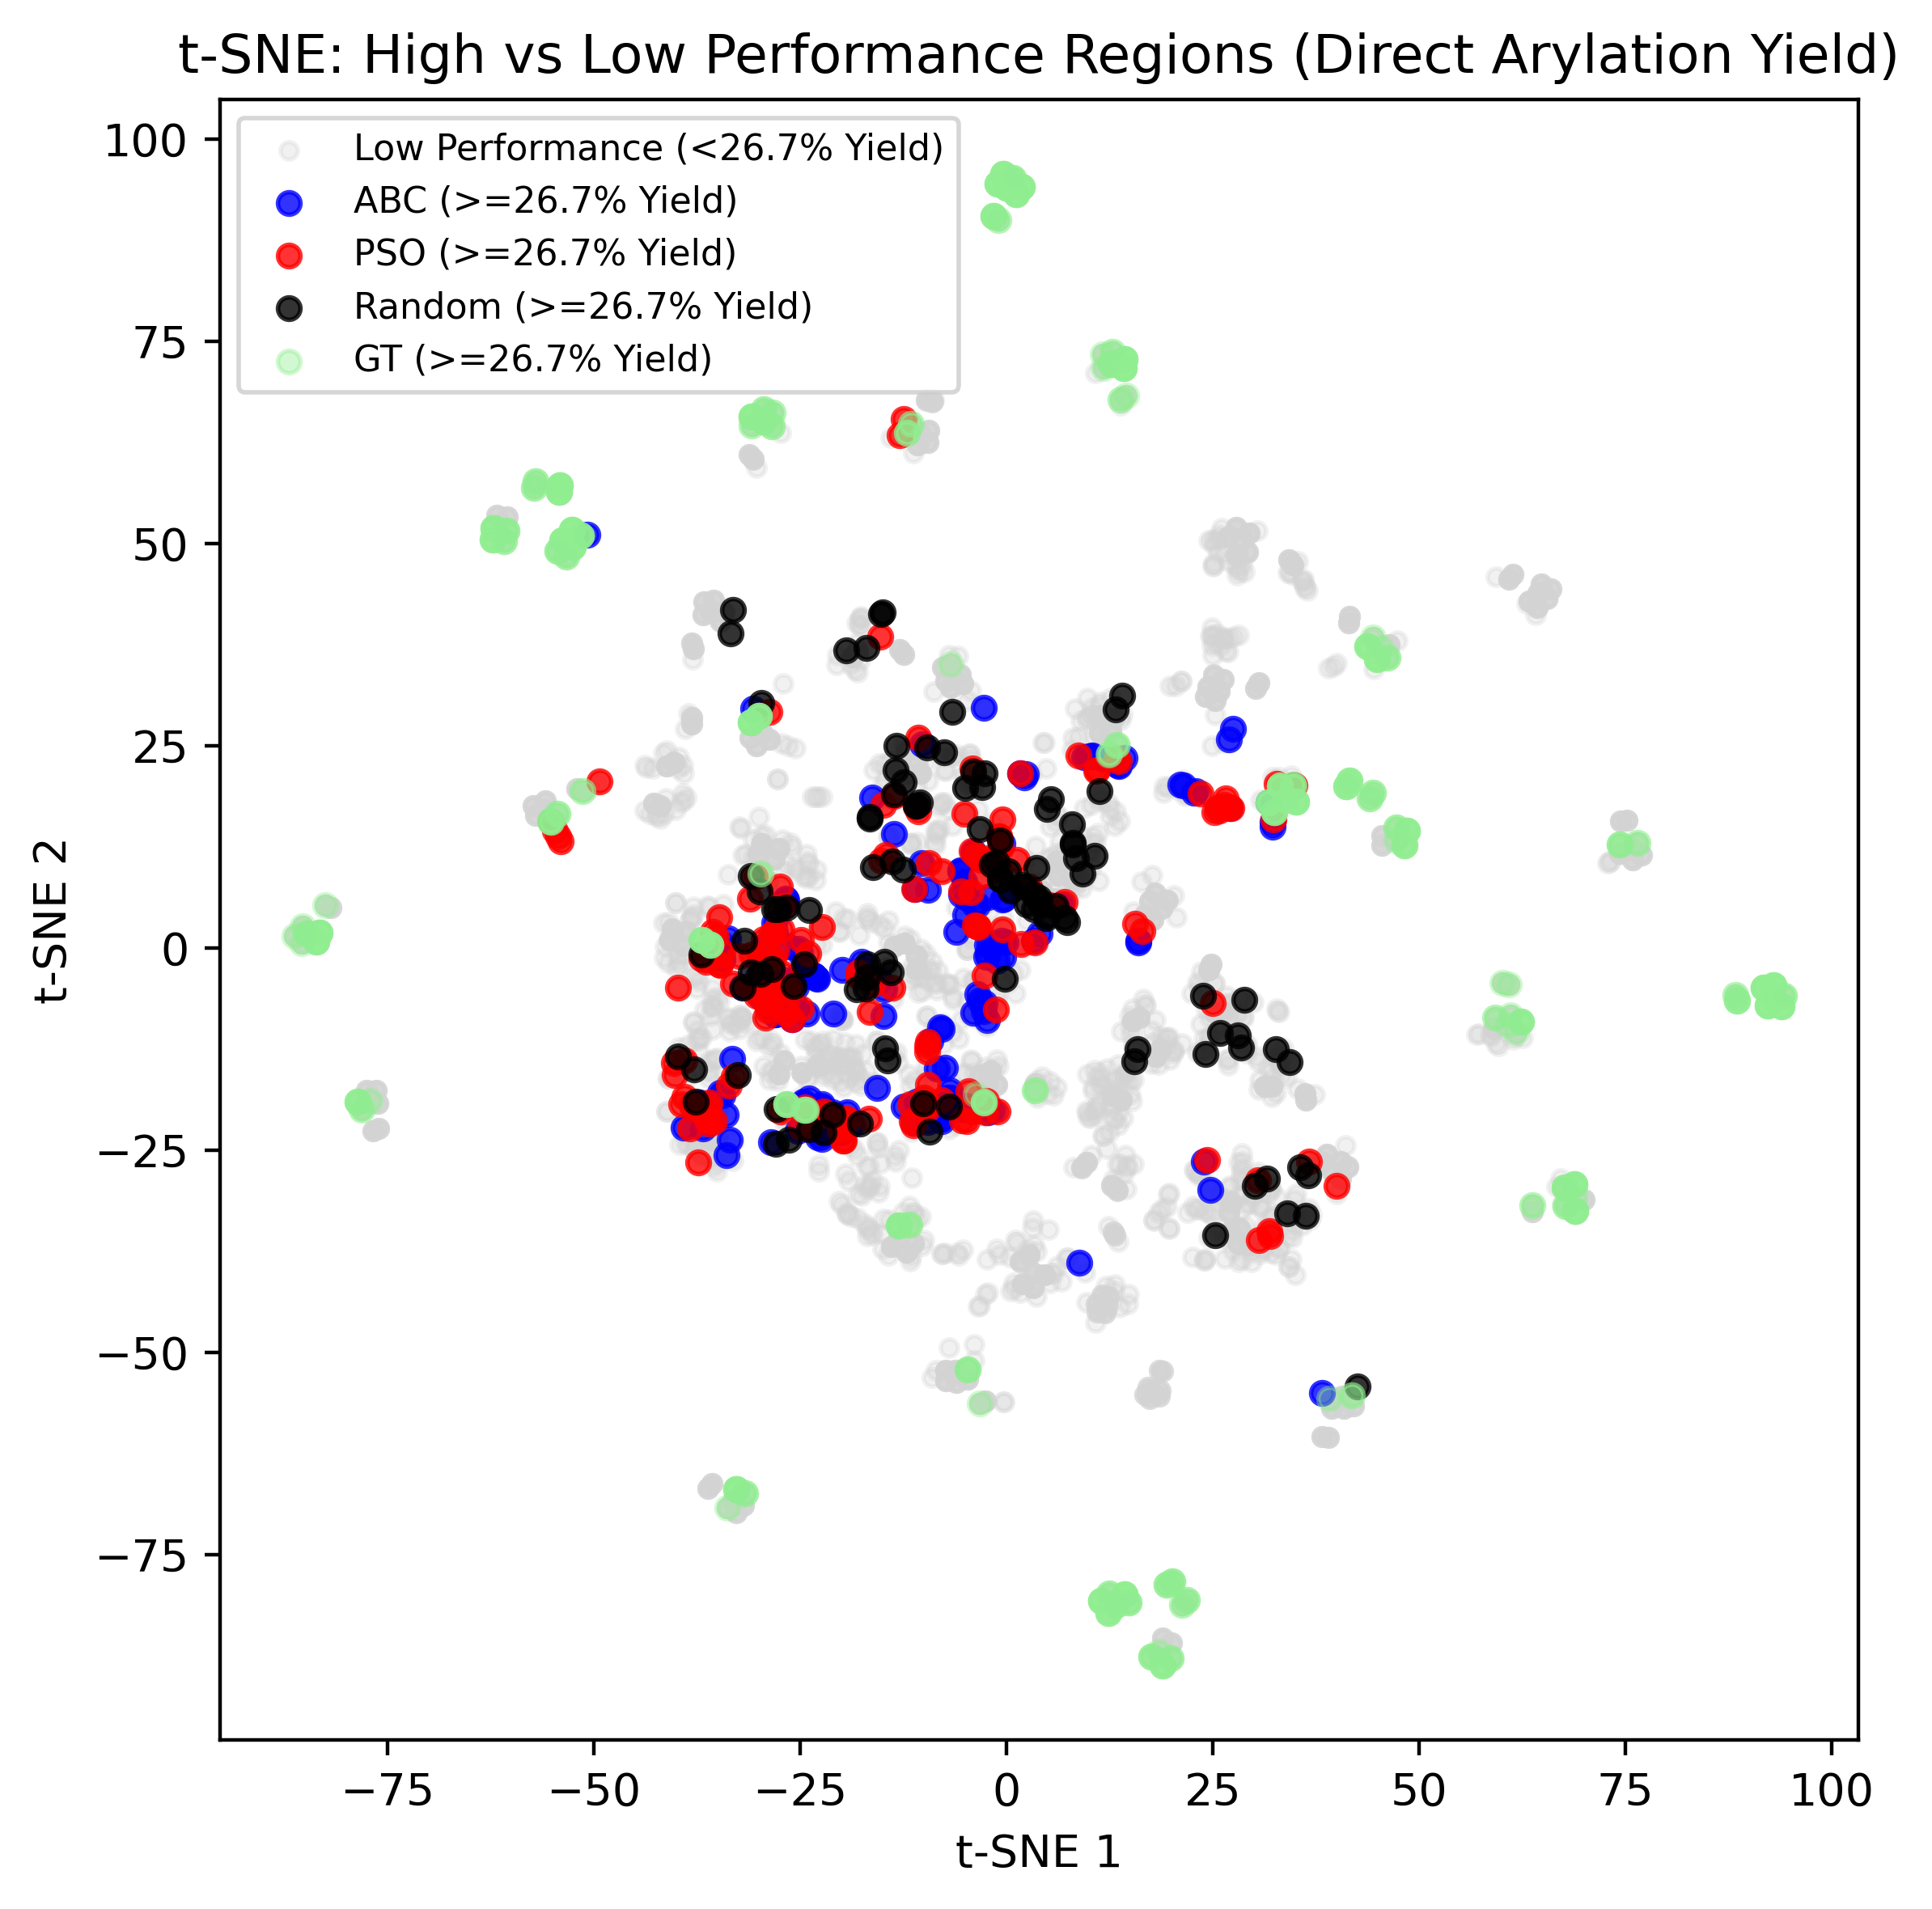

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# --- 直接 t-SNE ---
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=0,
    init='random'   # 可改 'pca' 看是否更穩定
)
c_df_tsne = tsne.fit_transform(c_df)

# --- 顏色設定 ---
method_colors = {'ABC': 'blue', 'PSO': 'red', 'Random': 'black', 'GT': 'lightgreen'}

plt.figure(figsize=(6, 6),dpi = 400)

# 低表現點（灰色底）
low_idx = np.where(Yield['yield'] < 26.7)[0]
plt.scatter(
    c_df_tsne[low_idx, 0],
    c_df_tsne[low_idx, 1],
    c='lightgray',
    alpha=0.3,
    s=15,
    label='Low Performance (<26.7% Yield)'
)

# 高表現點（彩色）
for method in method_colors:
    idx = [i for i, m in enumerate(labels) 
           if m == method and Yield['yield'].iloc[i] >= 26.7]
    if idx:
        # 調整 GT 的 alpha
        alpha_val = 0.4 if method == 'GT' else 0.8
        plt.scatter(
            c_df_tsne[idx, 0],
            c_df_tsne[idx, 1],
            c=[method_colors[method]],
            alpha=alpha_val,
            s=25,
            label=f'{method} (>=26.7% Yield)'
        )

plt.legend(fontsize = 8)
plt.title("t-SNE: High vs Low Performance Regions (Direct Arylation Yield)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


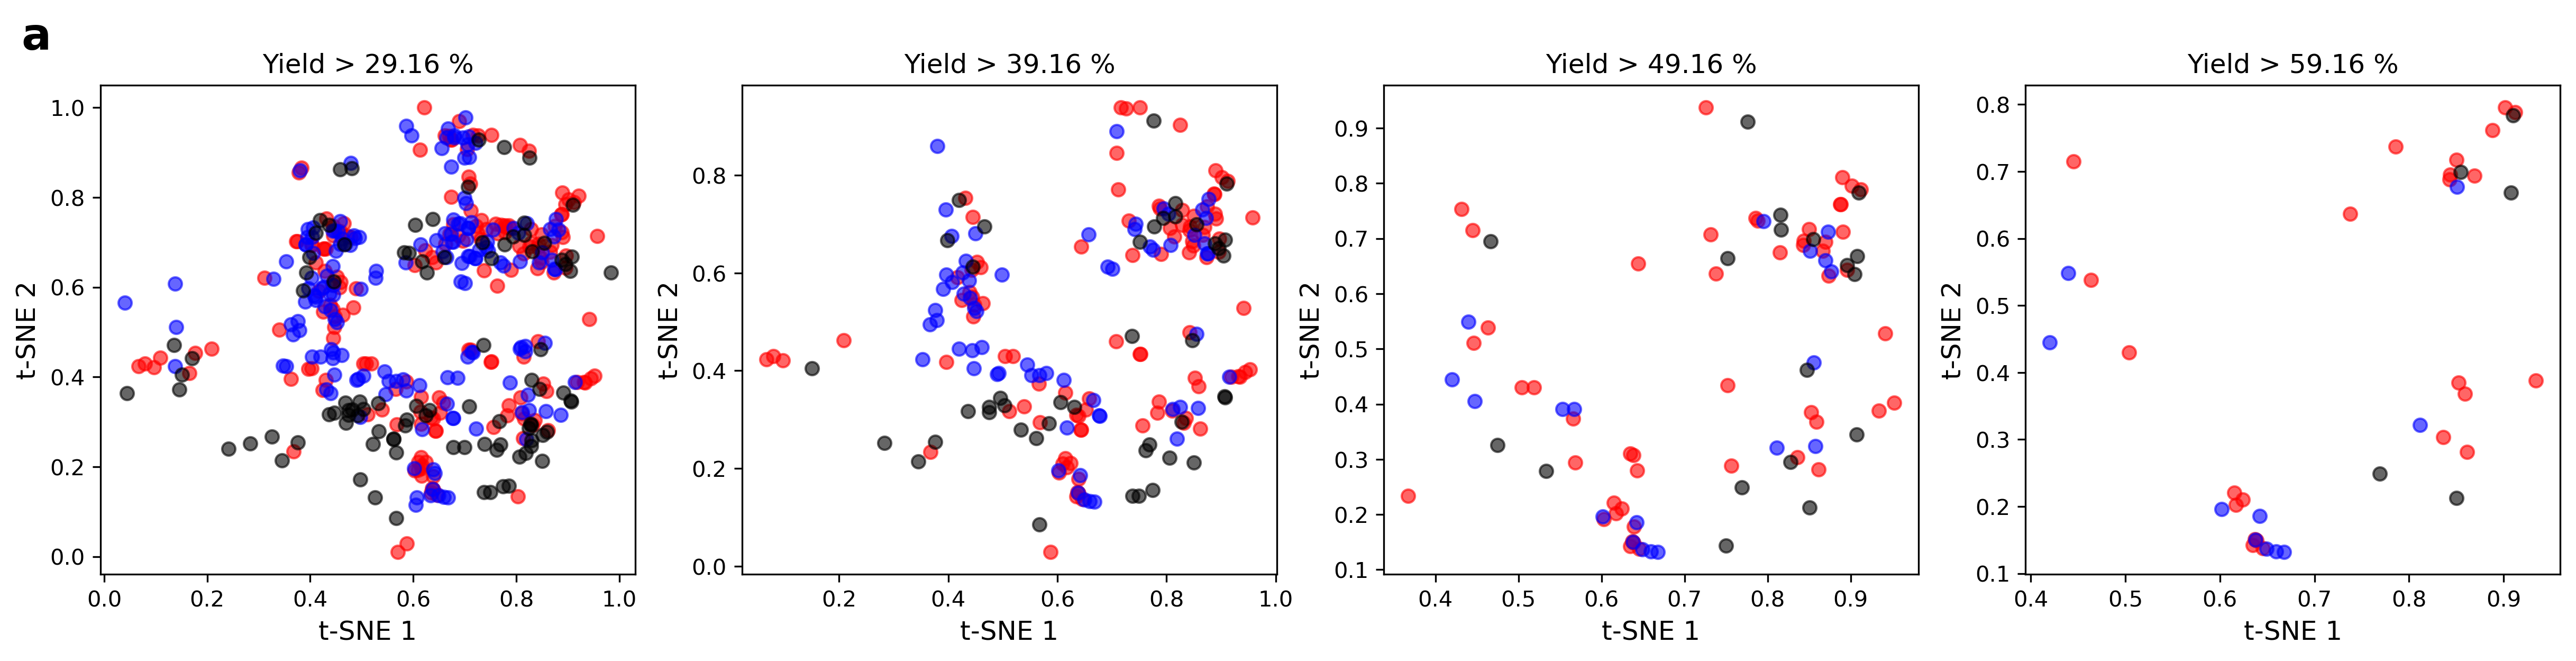

In [4]:
groups = ['group', 'group2','group3','group4']
nums = {'group':0, 'group2':1, 'group3':2, 'group4':3}
names = {'group':'29.16', 'group2':'39.16', 'group3':'49.16', 'group4':'59.16'}

fig, ax = plt.subplots(1, 4, figsize=(20, 4), dpi=300)

for group in groups:
    num = nums[group]
    name = names[group]
    
    ABC_cut = df1[df1[group]][['TSNE-1', 'TSNE-2']]
    PSO_cut = df2[df2[group]][['TSNE-1', 'TSNE-2']]
    random_cut = df3[df3[group]][['TSNE-1', 'TSNE-2']]
    ax[num].set_xlabel('t-SNE 1', fontsize = 12)
    ax[num].set_ylabel('t-SNE 2', fontsize = 12)
    ax[num].scatter(x=PSO_cut['TSNE-1'], y=PSO_cut['TSNE-2'],color='red', alpha=0.6, label='PSO')
    ax[num].scatter(x=ABC_cut['TSNE-1'], y=ABC_cut['TSNE-2'], color='blue', alpha=0.6, label='ABC')
    ax[num].scatter(x=random_cut['TSNE-1'], y=random_cut['TSNE-2'], color='black', alpha=0.6, label='Random')
    #ax[num].legend(frameon = False, loc = 'upper left', fontsize = 10)
    ax[num].set_title('Yield > '+name+" %")
fig.text(0.1, 0.99, 'a', fontsize=20, fontweight='bold',
         va='top', ha='left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/AllAryltsne.jpeg')

In [37]:
#合併圖片

from PIL import Image

# 讀入三張圖（確保路徑正確）
img1 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/ABCAryl.jpeg")
img2 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/PSOAryl.jpeg")
img3 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/RandomAryl.jpeg")

# 假設三張圖大小相同，取得寬高
width, height = img1.size

# 建立新圖像，寬度為三倍，垂直高度不變
new_img = Image.new('RGB', (width * 3, height))

# 將三張圖貼上去
new_img.paste(img3, (0, 0))
new_img.paste(img1, (width, 0))
new_img.paste(img2, (2 * width, 0))

# 儲存或顯示
new_img.save("/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/results_tsne.jpeg")
new_img.show()



(eog:55864): Gtk-WARNING **: 23:41:37.871: cannot open display: 


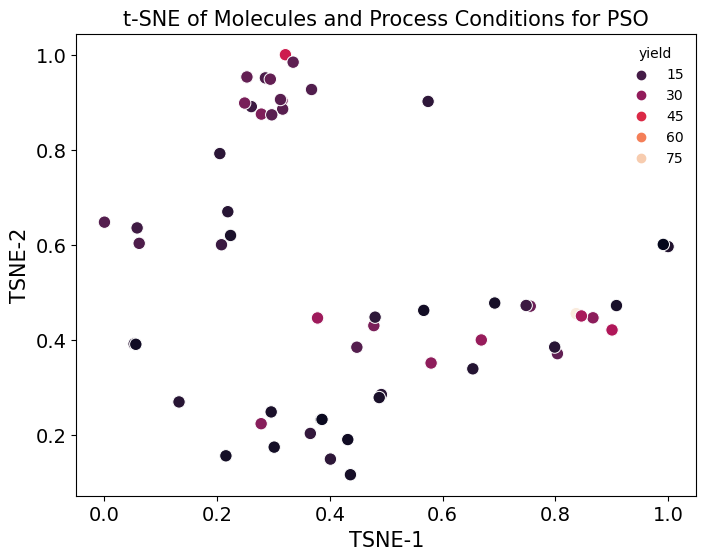

In [8]:
# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'yield', data=df2, palette='rocket',s=60)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for PSO', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon=False, title='yield')
plt.show()

/tmp/ipykernel_410/642810235.py:14: DeprecationWarning: Accessing jsonschema.draft3_format_checker is deprecated and will be removed in a future release. Instead, use the FORMAT_CHECKER attribute on the corresponding Validator.
  from jsonschema import draft3_format_checker
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

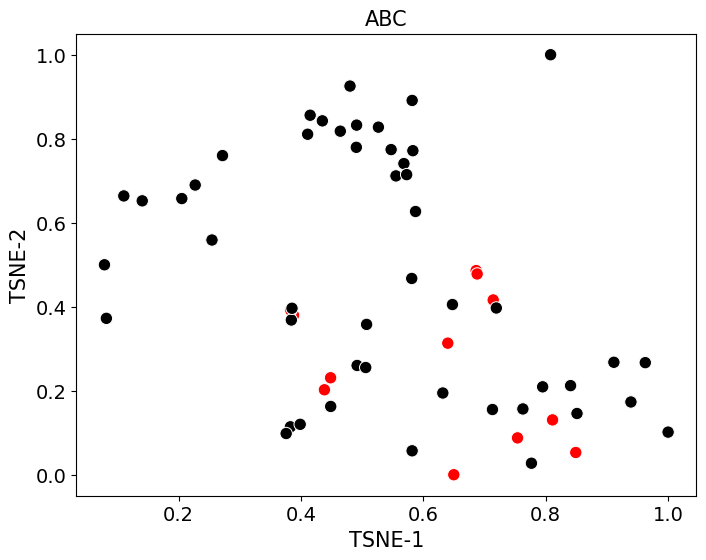

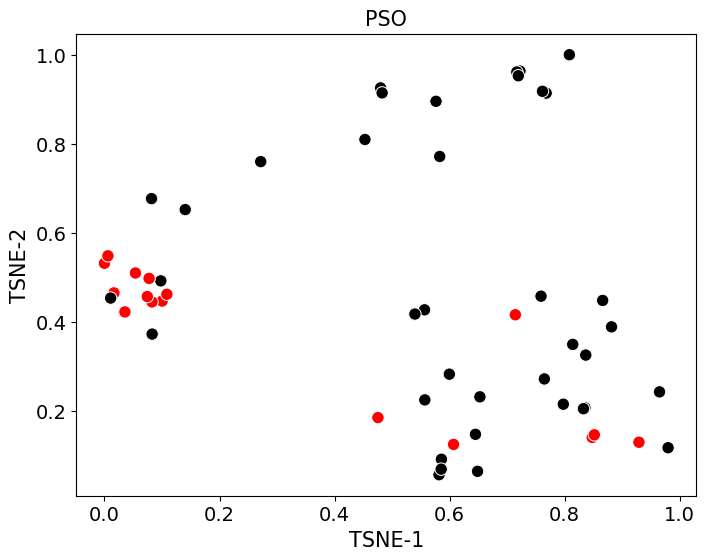

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

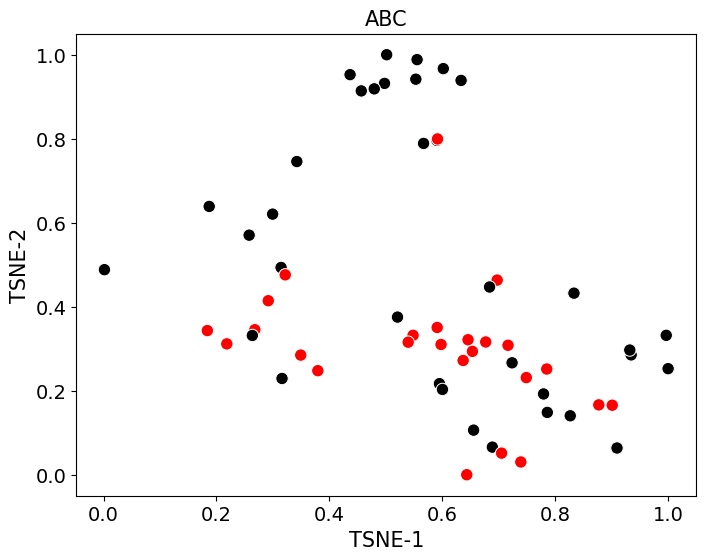

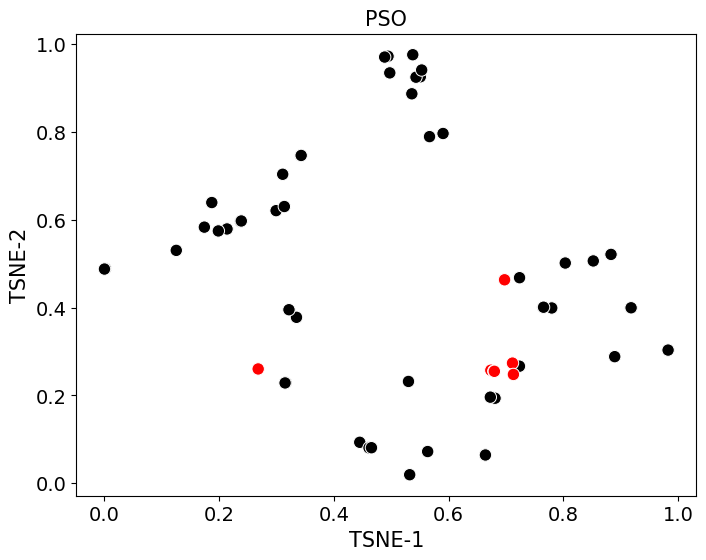

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

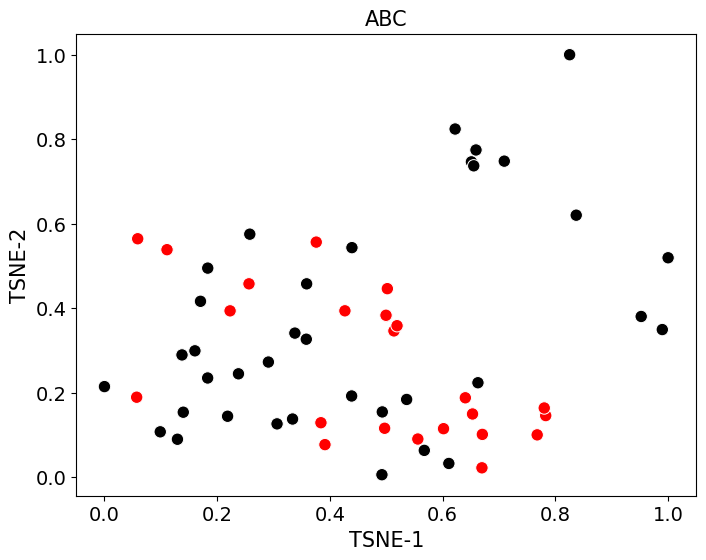

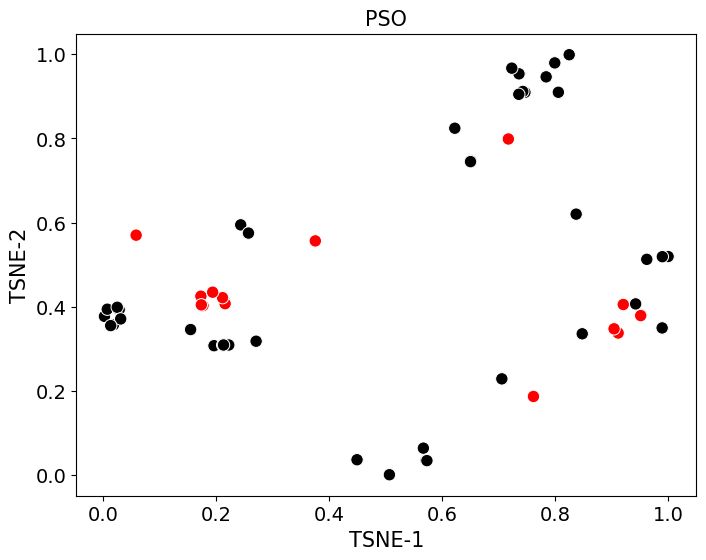

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

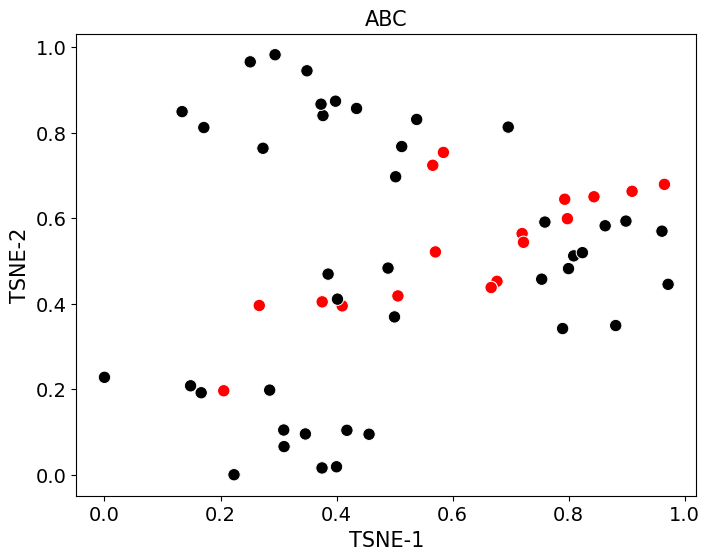

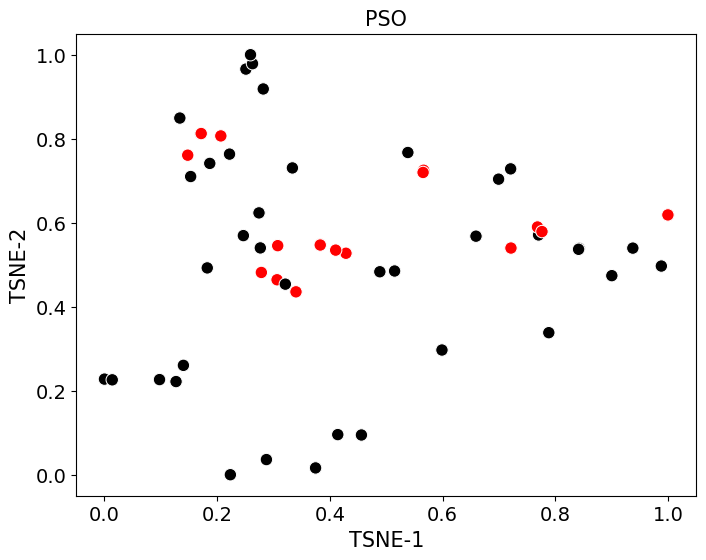

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

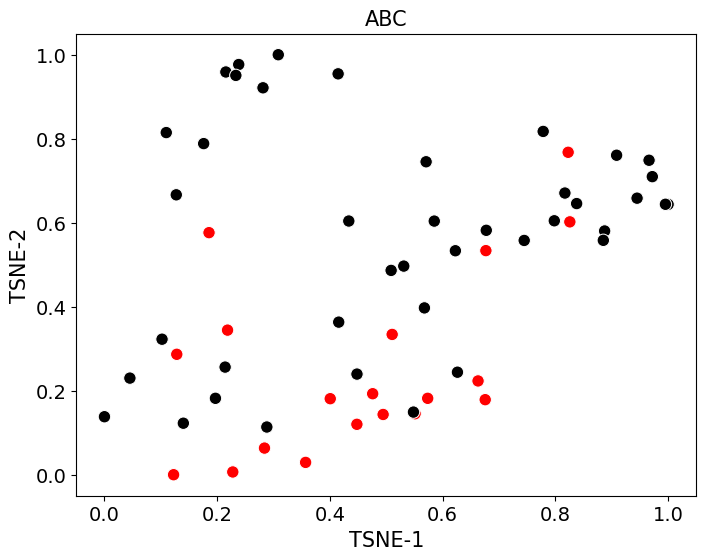

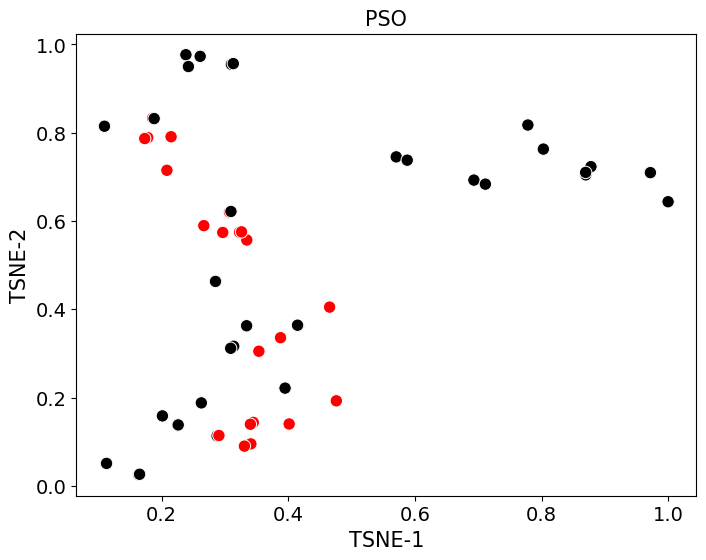

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

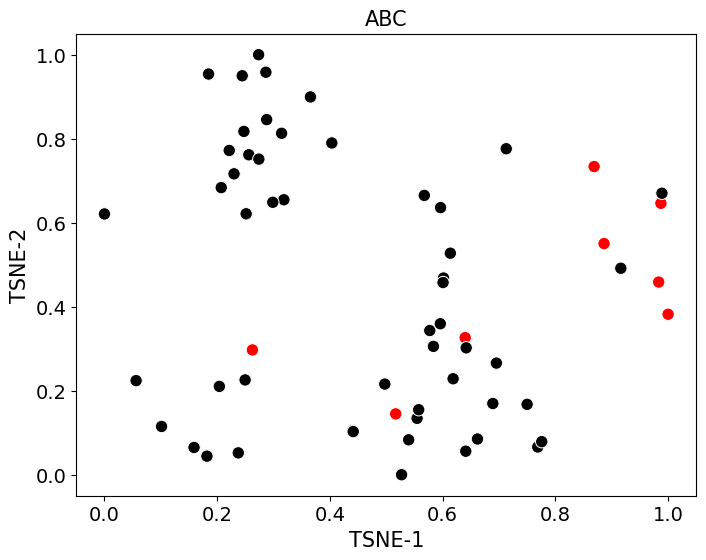

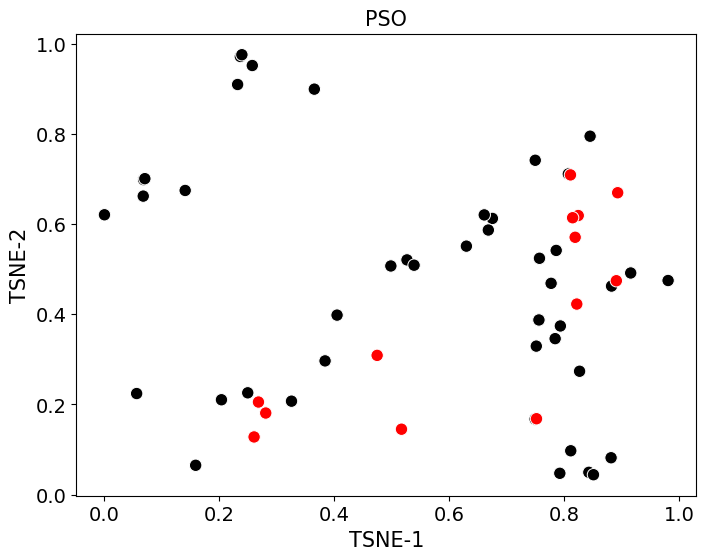

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

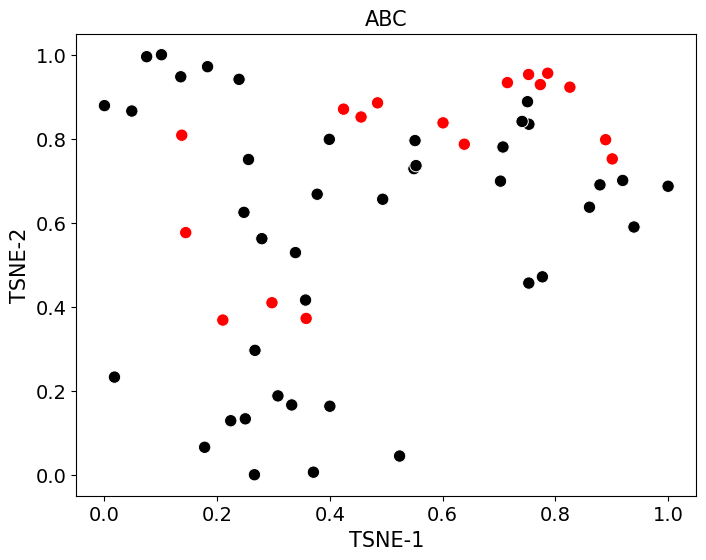

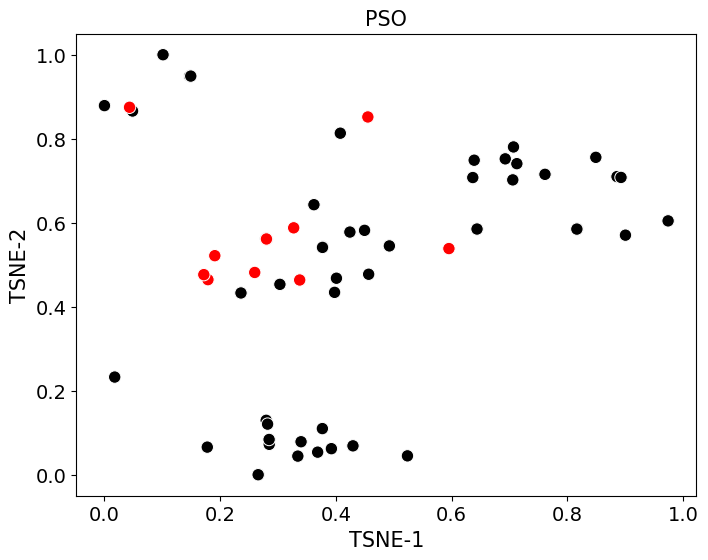

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

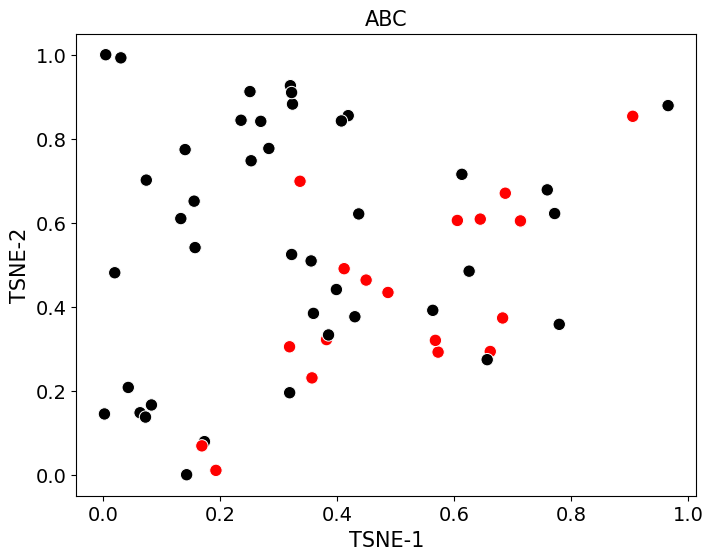

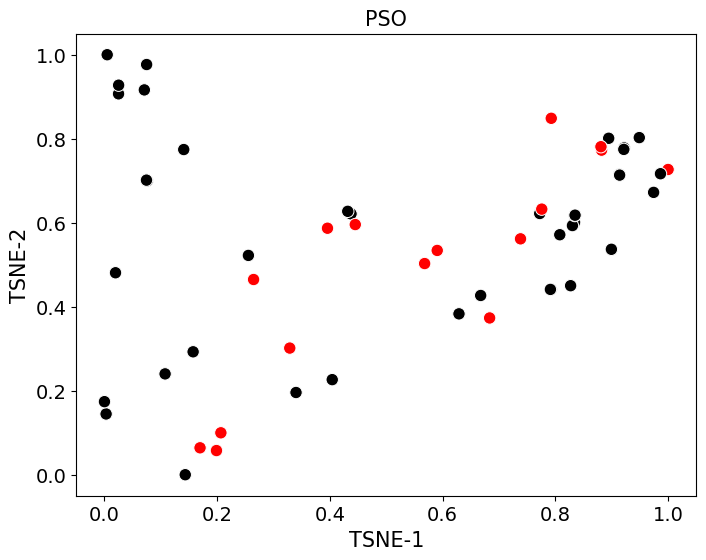

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

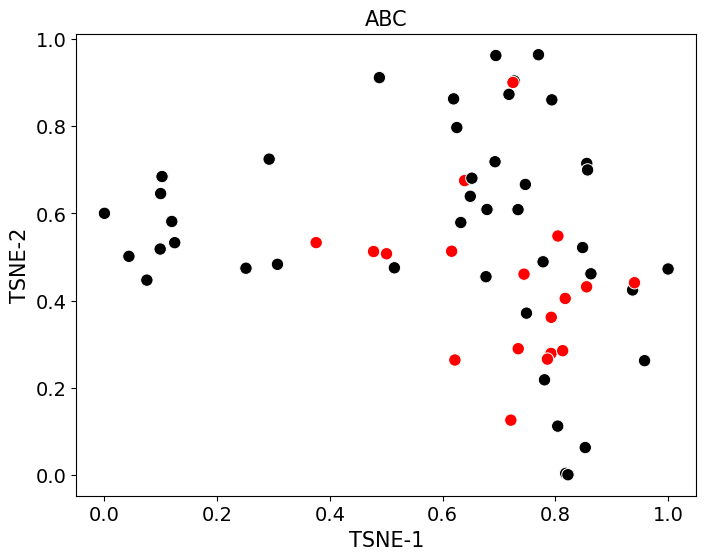

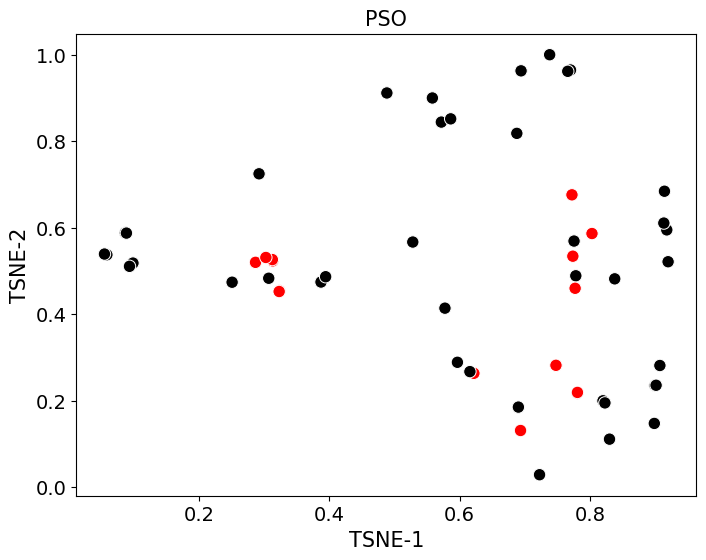

/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_410/642810235.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
/tmp/ipykernel_410/642810235.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

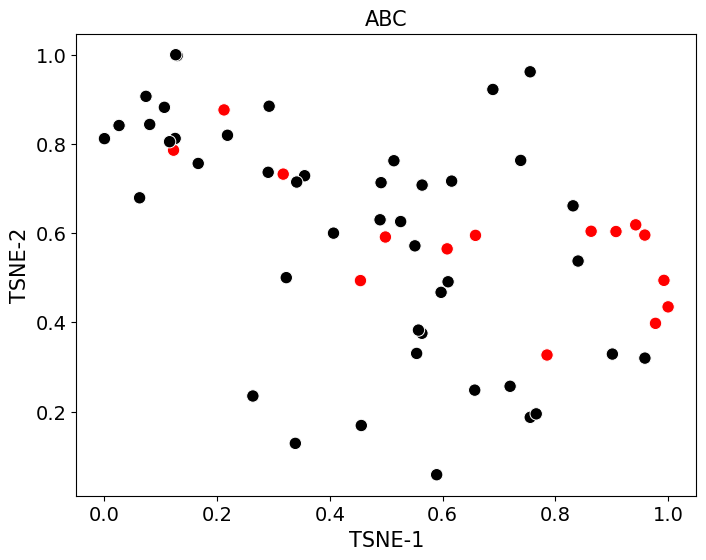

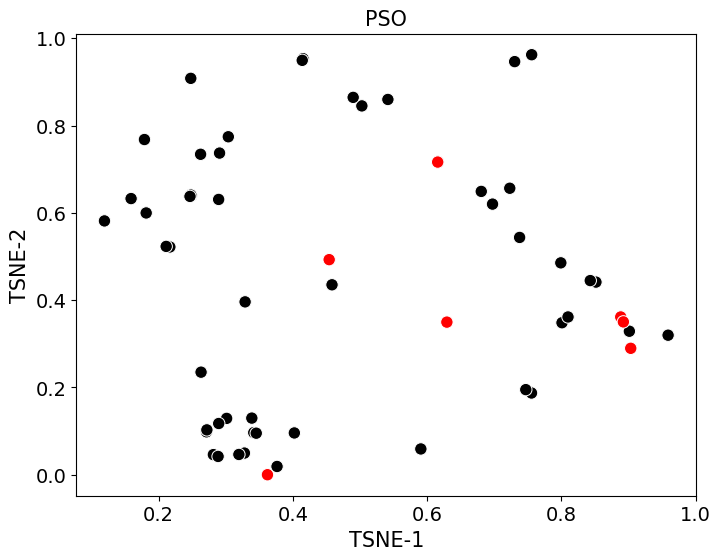

In [5]:
## draw all figure at the same time

import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
from rdkit.Chem import AllChem
from jsonschema import draft3_format_checker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler


feature_list =['Temp_C', 'Concentration']

for i in range(10):
    ABC = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/ABC/round{i+1}/cycle5.csv'
    PSO = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/PSO/round{i+1}/cycle5.csv'

    ABC = pd.read_csv(ABC)
    PSO = pd.read_csv(PSO)


    # 從SMILES生成Morgan fingerprints
    ABC_Lig_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['Ligand_SMILES']]
    ABC_Base_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['Base_SMILES']]
    ABC_Solv_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['Solvent_SMILES']]

    PSO_Lig_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['Ligand_SMILES']]
    PSO_Base_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['Base_SMILES']]
    PSO_Solv_fingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['Solvent_SMILES']]

    # 將fingerprints轉換為numpy數組
    ABCfp_array = np.concatenate((np.array([list(fp) for fp in ABC_Lig_fingerprints]), np.array([list(fp) for fp in ABC_Base_fingerprints]), np.array([list(fp) for fp in ABC_Solv_fingerprints])), axis=1)
    PSOfp_array = np.concatenate((np.array([list(fp) for fp in PSO_Lig_fingerprints]), np.array([list(fp) for fp in PSO_Base_fingerprints]), np.array([list(fp) for fp in PSO_Solv_fingerprints])), axis=1)

    fp_array = np.concatenate((ABCfp_array, PSOfp_array), axis=0)


    Yield = (pd.concat([ABC, PSO], ignore_index=True))[['yield']]
    ABC = ABC[feature_list]
    PSO = PSO[feature_list]

    #first combine without latent
    c_df = pd.concat([ABC, PSO], ignore_index=True)
    #c_df = data2

    c_df = c_df.values
    c_df = np.concatenate((c_df, fp_array), axis=1)

    # Apply t-SNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(c_df)

    # Normalize the t-SNE values
    scaler = MinMaxScaler()
    tsne_results_normalized = scaler.fit_transform(tsne_results)

    # Add a column to indicate the dataset
    ABC['dataset'] = 'ABC'
    PSO['dataset'] = 'PSO'

    ABC['yield'] = Yield.iloc[:60].values
    PSO['yield'] = Yield.iloc[60:120].values

    # Combine the datasets
    combined_df = pd.concat([ABC, PSO], ignore_index=True)
    #combined_df = data2

    # Add normalized t-SNE results to the DataFrame
    combined_df['TSNE-1'] = tsne_results_normalized[:, 0]
    combined_df['TSNE-2'] = tsne_results_normalized[:, 1]

    df1 = combined_df.iloc[:60]
    df2 = combined_df.iloc[60:120]

    threshold = 29.16

    df1['group'] = df1['yield'] > threshold  # 產生布林值欄位
    df2['group'] = df2['yield'] > threshold  # 產生布林值欄位


    # Plot the t-SNE results
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='TSNE-1', y='TSNE-2', data=df1,hue='group',palette={True: 'red', False: 'black'}, s=80, legend = False)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.title('ABC', fontsize=15)
    plt.xlabel('TSNE-1', fontsize = 15)
    plt.ylabel('TSNE-2', fontsize = 15)
    #plt.legend(frameon = False, title='yield')
    plt.show()

    # Plot the t-SNE results
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='TSNE-1', y='TSNE-2', data=df2,hue='group',palette={True: 'red', False: 'black'}, s=80, legend = False)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.title('PSO', fontsize=15)
    plt.xlabel('TSNE-1', fontsize = 15)
    plt.ylabel('TSNE-2', fontsize = 15)
    #plt.legend(frameon = False, title='yield')
    plt.show()

